In [8]:
# Setting up the Tesseract executable path
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

In [ ]:
import cv2
import numpy as np
import pytesseract
import re
import os
import json
import argparse
import pandas as pd
from dataclasses import dataclass
from typing import List, Tuple, Dict, Optional
import matplotlib.pyplot as plt

# Normalize Dates

In [3]:
def normalize_date(raw: str, verbose: bool=False) -> Optional[str]:
    if not raw:
        return None

    s = raw.strip()
    orig = s  # Keep original for verbose logging

    # Fix common OCR mistakes that confuse letters and digits
    s = s.replace('O','0').replace('o','0').replace('I','1').replace('l','1')
    s = s.replace('‘','1').replace('|','1')

    # Handle continuous 8-digit date like '20082000' (ddmmyyyy)
    # Convert it into '20.08.2000' format for easier parsing
    if re.fullmatch(r'\d{8}', s):
        d, mth, y = s[:2], s[2:4], s[4:]
        s = f"{d}.{mth}.{y}"
        if verbose:
            print(f"  normalize_date: converted continuous digits '{orig}' to '{s}'")

    else:
        # Replace common separators '/' or '-' with '.' for consistency
        s = re.sub(r'[\/\-]', '.', s)

    # Match date pattern: day.month.year where day/month can be 1 or 2 digits, year 2-4 digits
    m = re.match(r'^(\d{1,2})\.(\d{1,2})\.(\d{2,4})$', s)
    if not m:
        if verbose:
            print(f"  normalize_date: reject '{orig}' -> '{s}' (pattern mismatch)")
        return None

    d, mth, y = m.groups()

    # Pad day and month with leading zero if single digit (e.g., 3 -> 03)
    d = d.zfill(2)
    mth = mth.zfill(2)

    # Convert 2-digit years to 4-digit years based on cutoff 50
    if len(y) == 2:
        yy = int(y)
        y = f"20{y}" if yy < 50 else f"19{y}"

    # Validate day, month, and year ranges are plausible
    try:
        dd = int(d)
        mm = int(mth)
        yyyy = int(y)
        if not (1 <= dd <= 31 and 1 <= mm <= 12 and 1900 <= yyyy <= 2100):
            if verbose:
                print(f"  normalize_date: reject '{orig}' -> '{d}.{mth}.{y}' (implausible range)")
            return None
    except Exception:
        if verbose:
            print(f"  normalize_date: exception validating '{orig}'")
        return None

    norm = f"{d}.{mth}.{y}"
    if verbose and orig != norm:
        print(f"  normalize_date: '{orig}' normalized to '{norm}'")

    return norm

In [5]:
# Test strings to try out the function
test_dates = [
    "20082000",    # continuous digits, should become 20.08.2000
    "3/5/21",      # slash separator, short year, should become 03.05.2021
    "12-12-99",    # dash separator, should become 12.12.1999
    "01.01.2010",  # already formatted, should stay the same
    "O1/O1/2O2O",  # OCR mistakes with O and 0, should fix to 01.01.2020
    "31.13.2020",  # invalid month (13), should return None
    "29.02.20",    # leap year short year (2020), valid date but function only checks ranges, so accepted
    "abc",         # invalid format, should return None
    "",            # empty string, should return None
]


# Run normalization on test strings and print nicely formatted results
print(f"{'Raw Input':<15} | {'Normalized Output':<20} | Notes")
print("-" * 55)

for raw_date in test_dates:
    norm_date = normalize_date(raw_date, verbose=False)  # verbose=False to avoid internal prints
    
    if norm_date is None:
        note = "Rejected (invalid or implausible date)"
    elif norm_date != raw_date:
        note = "Normalized"
    else:
        note = "Unchanged"
    
    print(f"{raw_date:<15} | {str(norm_date):<20} | {note}")

Raw Input       | Normalized Output    | Notes
-------------------------------------------------------
20082000        | 20.08.2000           | Normalized
3/5/21          | 03.05.2021           | Normalized
12-12-99        | 12.12.1999           | Normalized
01.01.2010      | 01.01.2010           | Unchanged
O1/O1/2O2O      | 01.01.2020           | Normalized
31.13.2020      | None                 | Rejected (invalid or implausible date)
29.02.20        | 29.02.2020           | Normalized
abc             | None                 | Rejected (invalid or implausible date)
                | None                 | Rejected (invalid or implausible date)


# Best Rotation

In [6]:
def best_rotation_by_keyword(image: np.ndarray, keywords=('Department', 'Motor', 'Traffic', 'Sri', 'Lanka'), verbose: bool=False) -> Tuple[np.ndarray,int,Dict[int,int]]:
    # Prepare candidate images rotated by 0°, 90°, 180°, and 270° angles
    candidates = [
        (image, 0),  # original image, no rotation
        (cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE), 90),  # rotate 90 degrees clockwise
        (cv2.rotate(image, cv2.ROTATE_180), 180),  # rotate 180 degrees
        (cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE), 270)  # rotate 270 degrees clockwise (or 90 ccw)
    ]

    best_score = -1         # track highest keyword match count found so far
    best_img = image        # image corresponding to the best score (start with original)
    best_angle = 0          # angle corresponding to the best score
    scores = {}             # dictionary to store score per angle

    # Loop over each rotated candidate image and its angle
    for img, angle in candidates:
        # Convert image to grayscale for better OCR performance
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Apply adaptive thresholding to convert the image to black and white
        # This helps in extracting text more clearly during OCR
        proc = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 35, 15)
        
        # Run OCR on the processed image to extract text
        # --psm 6 assumes a single uniform block of text
        text = pytesseract.image_to_string(proc, config="--psm 6")
        
        # Count how many of the keywords appear in the extracted text (case-insensitive)
        score = sum(1 for k in keywords if k.lower() in text.lower())
        
        # Store this score with its corresponding angle
        scores[angle] = score
        
        # If verbose, print out the current trial angle and how many keywords were found
        if verbose:
            print(f"  Orientation trial angle={angle:3d} score={score} (keywords found)")
        
        # Update best score and best image if this rotation yields more keyword matches
        if score > best_score:
            best_score = score
            best_img = img
            best_angle = angle

    # After checking all rotations, optionally print the final chosen angle and score
    if verbose:
        print(f"  Selected rotation angle={best_angle} with score={best_score}")
    
    # Return:
    # - the image rotated to the best orientation,
    # - the rotation angle in degrees,
    # - dictionary of scores for each angle tried
    return best_img, best_angle, scores

  Orientation trial angle=  0 score=0 (keywords found)
  Orientation trial angle= 90 score=0 (keywords found)
  Orientation trial angle=180 score=4 (keywords found)
  Orientation trial angle=270 score=0 (keywords found)
  Selected rotation angle=180 with score=4

Final chosen rotation angle: 180°
Keyword match scores by angle: {0: 0, 90: 0, 180: 4, 270: 0}


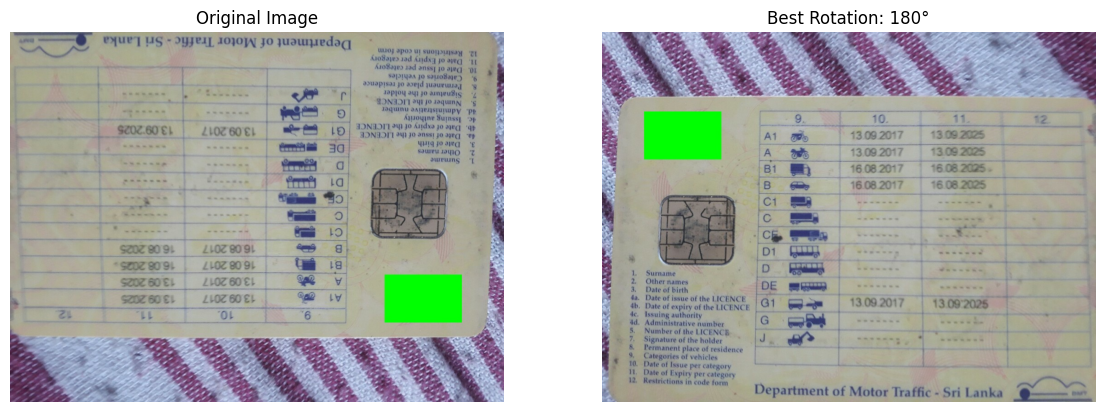

In [12]:
# Load the image (replace 'your_image.jpg' with your actual image file path)
image = cv2.imread('Images_all/230559.jpg')

if image is None:
    print("Error: Could not load image. Check your file path.")
else:
    # Run the rotation detection with verbose output
    rotated_img, angle, scores = best_rotation_by_keyword(image, verbose=True)
    
    print(f"\nFinal chosen rotation angle: {angle}°")
    print(f"Keyword match scores by angle: {scores}")
    
    # Display original and rotated images side by side for comparison
    fig, axs = plt.subplots(1, 2, figsize=(14, 8))
    
    # Convert BGR to RGB for correct color display in matplotlib
    axs[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[0].set_title("Original Image")
    axs[0].axis('off')
    
    axs[1].imshow(cv2.cvtColor(rotated_img, cv2.COLOR_BGR2RGB))
    axs[1].set_title(f"Best Rotation: {angle}°")
    axs[1].axis('off')
    
    plt.show()

# Deskew

In [10]:
def deskew_by_min_area_rect(image: np.ndarray, verbose: bool=False) -> Tuple[np.ndarray, float]:
    # Convert the input image to grayscale for simpler processing
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply Gaussian blur to reduce noise and smooth the image
    gray_blur = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Detect edges using Canny edge detector
    edges = cv2.Canny(gray_blur, 50, 150)
    
    # Extract coordinates (row, col) of all edge pixels
    coords = np.column_stack(np.where(edges > 0))
    
    # If there are too few edge points, skip deskewing as unreliable
    if coords.shape[0] < 50:
        if verbose:
            print("  Deskew: insufficient edge points, skipping")
        return image, 0.0  # Return original image and zero angle
    
    # Compute the minimum area rotated rectangle that bounds all edge points
    rect = cv2.minAreaRect(coords)
    
    # Extract the angle of the rectangle; angle is in range [-90, 0)
    angle = rect[-1]
    
    # Adjust angle to the correct deskew rotation if angle is less than -45°
    if angle < -45:
        angle = 90 + angle
    
    # Get image dimensions
    (h, w) = image.shape[:2]
    
    # Compute the rotation matrix to deskew the image around its center
    M = cv2.getRotationMatrix2D((w // 2, h // 2), angle, 1.0)
    
    # Rotate the image using the rotation matrix with cubic interpolation
    # Use border replicate to avoid black borders on rotation
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    
    # Print verbose info about the deskew angle applied
    if verbose:
        print(f"  Deskew applied angle={angle:.2f} degrees")
    
    # Return the rotated (deskewed) image and the angle used
    return rotated, angle


  Deskew applied angle=0.00 degrees
Detected deskew angle: 0.00 degrees


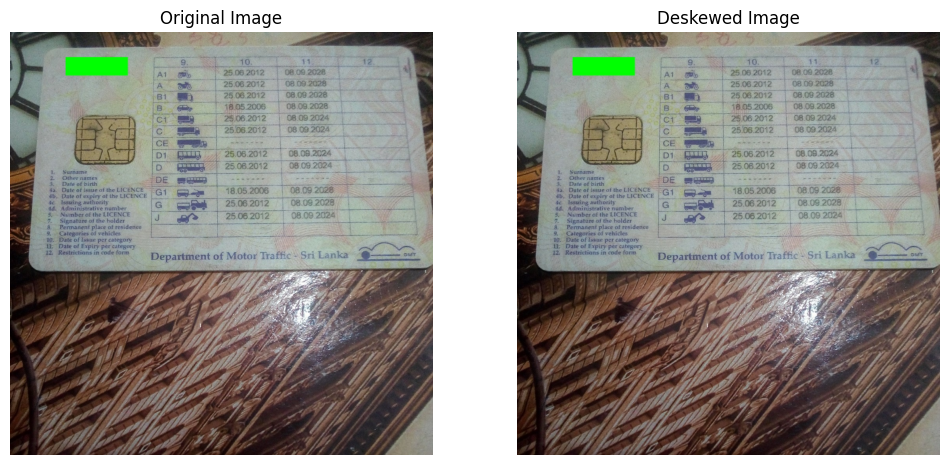

In [14]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Suppose your deskew function is already defined here or imported
# from your_module import deskew_by_min_area_rect

# Load the image (replace 'skewed_image.jpg' with your path)
image = cv2.imread('Images_all/345094.jpg')

# Check if image is loaded
if image is None:
    print("Error: Could not load image. Check the file path.")
else:
    # Run deskew with verbose output
    rotated_image, angle = deskew_by_min_area_rect(image, verbose=True)
    
    print(f"Detected deskew angle: {angle:.2f} degrees")
    
    # Show original and deskewed images side by side
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    
    # Convert BGR (OpenCV default) to RGB for correct color display
    axs[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[0].set_title('Original Image')
    axs[0].axis('off')
    
    axs[1].imshow(cv2.cvtColor(rotated_image, cv2.COLOR_BGR2RGB))
    axs[1].set_title('Deskewed Image')
    axs[1].axis('off')
    
    plt.show()

Need to correct this

# Detect Table Region

In [17]:
def locate_table_region(image: np.ndarray, verbose: bool=False) -> np.ndarray:
    # Convert input image to grayscale for processing
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Enhance local contrast using CLAHE to make lines clearer
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray = clahe.apply(gray)
    
    # Adaptive threshold to create a binary image with text/lines as white (inverted)
    bw = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY_INV, 31, 9)

    # Create horizontal and vertical structuring elements (kernels) for morphology
    horiz_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (40, 1))
    vert_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 40))
    
    # Extract horizontal lines by morphological opening
    horiz = cv2.morphologyEx(bw, cv2.MORPH_OPEN, horiz_kernel, iterations=1)
    # Extract vertical lines similarly
    vert = cv2.morphologyEx(bw, cv2.MORPH_OPEN, vert_kernel, iterations=1)
    
    # Combine horizontal and vertical lines to get grid-like structure
    grid = cv2.add(horiz, vert)
    
    # Dilate grid to thicken lines and close gaps
    grid = cv2.dilate(grid, cv2.getStructuringElement(cv2.MORPH_RECT, (3,3)), iterations=1)

    # Find contours in the grid image — each contour corresponds to a connected component
    contours, _ = cv2.findContours(grid, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Get image height and width for size constraints
    h, w = image.shape[:2]
    
    candidate = None         # To hold the best candidate bounding box for the table
    candidate_area = 0       # Track largest area found that meets size criteria

    # Loop over all contours to find the bounding box that most likely corresponds to the table
    for cnt in contours:
        x, y, ww, hh = cv2.boundingRect(cnt)   # Get bounding rectangle of contour
        area = ww * hh                         # Calculate area of bounding box
        
        # Check if bounding box meets size constraints relative to the whole image
        # This filters out too small or too large boxes unlikely to be the table
        if area > candidate_area and 0.1*w < ww < 0.95*w and 0.2*h < hh < 0.9*h:
            candidate_area = area
            candidate = (x, y, ww, hh)

    # If a suitable candidate bounding box was found, crop and return that region
    if candidate:
        x, y, ww, hh = candidate
        if verbose:
            print(f"  Table ROI detected at x={x}, y={y}, w={ww}, h={hh}, area={candidate_area}")
        return image[y:y+hh, x:x+ww]
    
    # Otherwise, if no suitable candidate was found, return the whole image
    else:
        if verbose:
            print("  Table ROI NOT detected; using full image")
        return image

  Table ROI detected at x=222, y=504, w=539, h=421, area=226919
Detected table region saved to: Images_all/331520_table_region.jpg


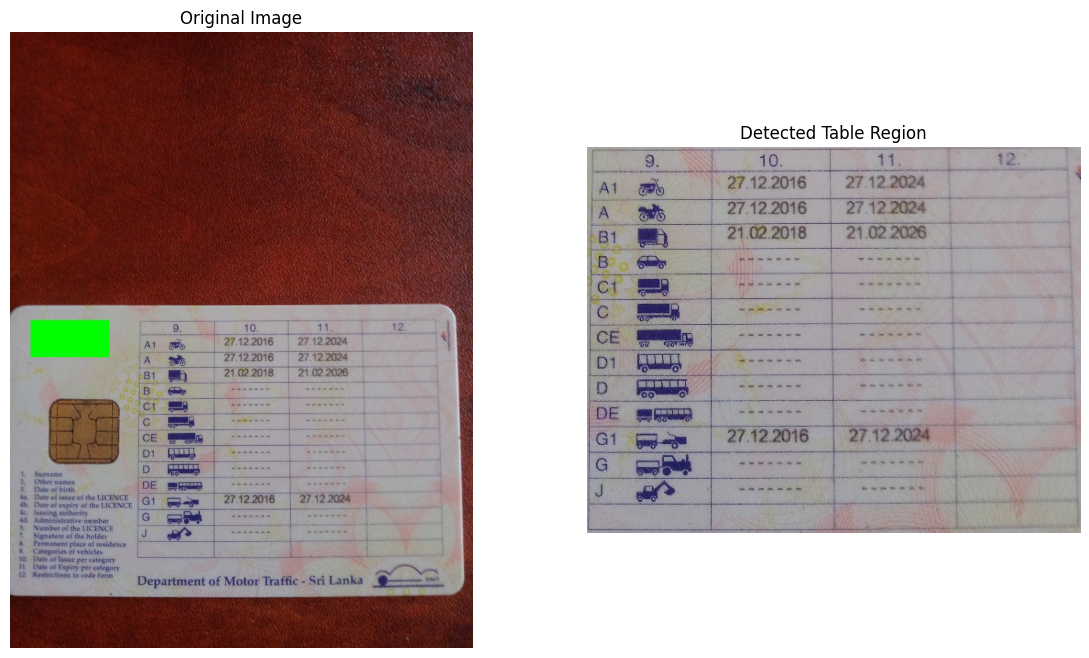

In [18]:
# Make sure locate_table_region function is defined or imported above this cell

# Load the image - replace 'your_image.jpg' with your actual file path
image = cv2.imread('Images_all/331520.jpg')

if image is None:
    print("Error: Could not load image. Check your file path.")
else:
    # Run the function with verbose=True to see debug prints
    table_region = locate_table_region(image, verbose=True)
    
    # Save the detected table region image
    save_path = 'Images_all/331520_table_region.jpg'
    cv2.imwrite(save_path, table_region)
    print(f"Detected table region saved to: {save_path}")
    
    # Display original image and cropped table region side-by-side
    fig, axs = plt.subplots(1, 2, figsize=(14, 8))
    
    # Convert BGR to RGB for matplotlib display
    axs[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[0].set_title("Original Image")
    axs[0].axis('off')
    
    axs[1].imshow(cv2.cvtColor(table_region, cv2.COLOR_BGR2RGB))
    axs[1].set_title("Detected Table Region")
    axs[1].axis('off')
    
    plt.show()


# Split Rows

In [ ]:
# Bad
def split_rows(roi: np.ndarray, expected_min_rows=8, verbose: bool=False) -> List[np.ndarray]:
    # Convert input image (ROI) to grayscale for thresholding
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    
    # Apply Otsu's thresholding to binarize the image (automatic threshold selection)
    _, th = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Invert the binary image: text and lines become white (255), background black (0)
    inv = 255 - th
    
    # Calculate horizontal projection by summing pixel values across each row
    # Rows containing text or lines will have higher sums
    projection = inv.sum(axis=1)
    
    # Normalize the projection to range [0, 1] for stable thresholding
    projection_norm = (projection - projection.min()) / (np.ptp(projection) + 1e-5)
    
    # Create a binary mask where rows with normalized sum > 0.15 are considered content rows
    mask = projection_norm > 0.15
    
    rows = []
    start = None
    
    # Detect continuous segments of content rows
    for i, val in enumerate(mask):
        if val and start is None:
            start = i  # start of a content segment
        if not val and start is not None:
            # end of a content segment
            if i - start > 10:  # ignore very small segments (noise)
                rows.append((start, i))
            start = None
    
    # Handle segment that continues till the end of the image
    if start is not None and len(mask) - start > 10:
        rows.append((start, len(mask)))

    fallback_used = False
    
    # If fewer rows detected than expected, fallback to evenly slicing the ROI height
    if len(rows) < expected_min_rows:
        if verbose:
            print(f"  Row segmentation found {len(rows)} rows; using fallback slicing")
        
        h = roi.shape[0]
        slice_h = h // (expected_min_rows + 2)
        rows = []
        for k in range(expected_min_rows + 2):
            y1 = k * slice_h
            y2 = (k + 1) * slice_h
            if y2 - y1 > 12:  # ignore too-thin slices
                rows.append((y1, y2))
        fallback_used = True

    # Crop the detected rows out of the ROI image
    row_imgs = [roi[y1:y2, :] for (y1, y2) in rows]

    filtered = []
    for idx, r in enumerate(row_imgs):
        if r.size == 0:
            continue  # skip empty slices
        
        # Convert to grayscale and check if row contains enough dark pixels to be considered non-empty
        g = cv2.cvtColor(r, cv2.COLOR_BGR2GRAY)
        if (g < 250).sum() > g.size * 0.01:  # more than 1% of pixels are not near white
            filtered.append(r)

    if verbose:
        print(f"  Row segmentation: raw segments={len(rows)}, filtered={len(filtered)}, fallback_used={fallback_used}")
    
    return filtered

In [ ]:
#Ok

def split_rows_improved(roi: np.ndarray, expected_min_rows=8, verbose: bool=False) -> List[np.ndarray]:
    # Convert to grayscale
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)

    # Binarize with Otsu thresholding
    _, th = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Invert so text/lines are white
    inv = 255 - th

    # Morphological closing to connect components horizontally (helps unify rows)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (roi.shape[1]//30, 3))
    closed = cv2.morphologyEx(inv, cv2.MORPH_CLOSE, kernel)

    # Horizontal projection: sum of white pixels per row
    projection = closed.sum(axis=1)

    # Smooth the projection to reduce noise
    projection_smooth = cv2.GaussianBlur(projection.reshape(-1,1), (7,1), 0).flatten()

    # Find valleys in projection as potential row separators
    # Valleys correspond to local minima below a threshold
    threshold_valley = np.max(projection_smooth) * 0.15
    minima = (np.diff(np.sign(np.diff(projection_smooth))) > 0).nonzero()[0] + 1  # local minima indices
    separators = [0] + [m for m in minima if projection_smooth[m] < threshold_valley] + [len(projection_smooth)]

    # Filter separators that are too close
    filtered_separators = [separators[0]]
    min_distance = roi.shape[0] // (expected_min_rows * 2)
    for sep in separators[1:]:
        if sep - filtered_separators[-1] > min_distance:
            filtered_separators.append(sep)

    # Create row slices between separators
    rows = []
    for i in range(len(filtered_separators) - 1):
        y1, y2 = filtered_separators[i], filtered_separators[i+1]
        if y2 - y1 > 5:  # ignore very thin rows
            rows.append((y1, y2))

    # Fallback if not enough rows found
    fallback_used = False
    if len(rows) < expected_min_rows:
        if verbose:
            print(f"  Row segmentation found {len(rows)} rows; using fallback slicing")

        h = roi.shape[0]
        slice_h = h // (expected_min_rows + 2)
        rows = []
        for k in range(expected_min_rows + 2):
            y1 = k * slice_h
            y2 = (k + 1) * slice_h
            if y2 - y1 > 12:
                rows.append((y1, y2))
        fallback_used = True

    # Crop rows
    row_imgs = [roi[y1:y2, :] for (y1, y2) in rows]

    # Filter out empty slices (mostly white)
    filtered = []
    for idx, r in enumerate(row_imgs):
        if r.size == 0:
            continue
        g = cv2.cvtColor(r, cv2.COLOR_BGR2GRAY)
        if (g < 250).sum() > g.size * 0.01:
            filtered.append(r)

    if verbose:
        print(f"  Row segmentation: raw segments={len(rows)}, filtered={len(filtered)}, fallback_used={fallback_used}")

    return filtered


In [ ]:
# Better

def split_rows_better(roi: np.ndarray, expected_min_rows=8, verbose: bool=False) -> List[np.ndarray]:
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    _, th = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    inv = 255 - th  # text/lines = white, background = black

    h, w = inv.shape

    # Morphologically dilate horizontally to close small gaps within text lines (connect characters)
    horiz_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (w // 30, 1))
    dilated = cv2.dilate(inv, horiz_kernel, iterations=1)

    # Find rows of whitespace (black) between text by detecting horizontal white gaps in the inverted image
    # Invert dilated so whitespace is white, text is black
    dilated_inv = 255 - dilated

    # Morphological opening vertically to isolate whitespace bands between rows
    vert_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, max(h // 60, 1)))
    opened = cv2.morphologyEx(dilated_inv, cv2.MORPH_OPEN, vert_kernel)

    # Find contours of whitespace bands
    contours, _ = cv2.findContours(opened, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Sort contours top to bottom
    contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[1])

    # Extract y-coordinates of whitespace bands (these will be row separators)
    separators = []
    for cnt in contours:
        x, y, cw, ch = cv2.boundingRect(cnt)
        if ch > 3:  # ignore very thin lines, tweak threshold if needed
            separators.append((y, y + ch))

    # Add image top and bottom as implicit separators
    separators = [(0, 0)] + separators + [(h, h)]

    # Build rows by slicing between whitespace bands, adding a small padding to avoid cutting text
    padding = max(h // 200, 2)
    rows = []
    for i in range(len(separators) - 1):
        y_start = separators[i][1] - padding
        y_end = separators[i+1][0] + padding

        y_start = max(0, y_start)
        y_end = min(h, y_end)

        if y_end - y_start > 15:  # minimum height for a row
            rows.append((y_start, y_end))

    # Fallback with overlapping slices if too few rows detected
    if len(rows) < expected_min_rows:
        if verbose:
            print(f"  Few rows detected ({len(rows)}); using fallback with overlap")

        rows = []
        slice_h = h // expected_min_rows
        overlap = max(slice_h // 10, 5)
        for i in range(expected_min_rows):
            y_start = max(0, i * slice_h - overlap)
            y_end = min(h, (i + 1) * slice_h + overlap)
            rows.append((y_start, y_end))

    # Crop rows and filter empty ones
    row_imgs = []
    for (y1, y2) in rows:
        crop = roi[y1:y2, :]
        if crop.size == 0:
            continue
        g = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
        if (g < 250).sum() > g.size * 0.01:  # non-empty threshold
            row_imgs.append(crop)

    if verbose:
        print(f"  Final row count: {len(row_imgs)} (raw: {len(rows)})")

    return row_imgs

In [ ]:
import cv2
from matplotlib import pyplot as plt

# Paste or import split_rows function here

# Load a sample table image (ROI) - replace 'table_sample.jpg' with your actual image path
roi = cv2.imread('Images_all/331520_table_region.jpg')

if roi is None:
    print("Error: Could not load image. Check your file path.")
else:
    # Run split_rows with verbose to see debug info
    # rows = split_rows(roi, expected_min_rows=8, verbose=True)
    # rows = split_rows_better(roi, expected_min_rows=8, verbose=True)
    rows = split_rows_improved(roi, expected_min_rows=8, verbose=True)
    
    print(f"\nTotal rows extracted: {len(rows)}")

    # Plot extracted rows one below the other
    fig, axs = plt.subplots(len(rows), 1, figsize=(10, len(rows) * 2))
    if len(rows) == 1:
        axs = [axs]  # make iterable if only one row

    for i, r_img in enumerate(rows):
        axs[i].imshow(cv2.cvtColor(r_img, cv2.COLOR_BGR2RGB))
        axs[i].axis('off')
        axs[i].set_title(f"Row {i+1}")

    plt.tight_layout()
    plt.show()


Can Improve this

In [28]:
import cv2
import numpy as np
import pytesseract
from typing import Optional

def ocr_cell_image(img: np.ndarray, verbose: bool=False, row_index: Optional[int]=None) -> str:
    # Convert image to grayscale (simplifies image for OCR)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Denoise image to reduce noise and improve OCR accuracy
    gray = cv2.fastNlMeansDenoising(gray, h=15)
    
    # Apply adaptive mean thresholding to get a binary (black & white) image
    thr = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                cv2.THRESH_BINARY, 27, 11)
    
    # Dilate white pixels slightly to make characters more prominent for OCR
    thr = cv2.dilate(thr, np.ones((1, 1), np.uint8), iterations=1)
    
    # Tesseract OCR config:
    # --oem 3: Use LSTM OCR Engine
    # --psm 6: Assume a uniform block of text
    # tessedit_char_whitelist: Restrict characters to digits, uppercase letters, and some punctuation
    config = "--oem 3 --psm 6 -c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ.-/"
    
    # Run OCR on the processed image and strip surrounding whitespace
    text = pytesseract.image_to_string(thr, config=config).strip()
    
    # If verbose, print a short snippet of the OCR result for inspection
    if verbose:
        snippet = text.replace("\n", " ")
        if len(snippet) > 80:
            snippet = snippet[:77] + "..."
        print(f"    OCR row {row_index if row_index is not None else ''}: '{snippet}'")
    
    # Return the extracted text string
    return text


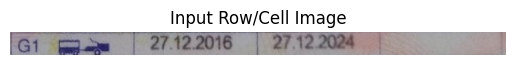

    OCR row 1: '1G1C2712201827122024'

Extracted text:
1G1C2712201827122024


In [29]:
import cv2
from matplotlib import pyplot as plt

# Paste or import your ocr_cell_image function here

# Load a sample cropped row or cell image - replace 'row_sample.jpg' with your file path
img = cv2.imread('Images_all/row_sample.jpg')

if img is None:
    print("Error: Could not load image. Check your file path.")
else:
    # Optionally display the input image
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Input Row/Cell Image")
    plt.axis('off')
    plt.show()
    
    # Run OCR on the image
    text = ocr_cell_image(img, verbose=True, row_index=1)
    
    print(f"\nExtracted text:\n{text}")

Can improve this as well

# Parse dates (with Normalized dates - why?)

In [ ]:
import re
from typing import Optional, Tuple

# Vehicle classes list
VEHICLE_CLASSES = ["A1","A","B1","B","C1","C","CE","D1","D","DE","G1","G","J"]

# Date regex to match dd.mm.yyyy, dd/mm/yyyy, dd-mm-yyyy, etc.
DATE_REGEX = re.compile(r'\b(\d{1,2}[.\-\/]\d{1,2}[.\-\/]\d{2,4})\b')

def normalize_date(raw: str, verbose: bool=False) -> Optional[str]:
    """
    Normalize date string to dd.mm.yyyy format.
    Handles OCR common errors and flexible separators.
    Returns None if date is invalid or format doesn't match.
    """
    if not raw:
        return None

    s = raw.strip()
    orig = s  # Save original for debug

    # Correct common OCR errors
    s = s.replace('O','0').replace('o','0').replace('I','1').replace('l','1')
    s = s.replace('‘','1').replace('|','1')

    # Convert continuous 8-digit date like '20082000' -> '20.08.2000'
    if re.fullmatch(r'\d{8}', s):
        d, mth, y = s[:2], s[2:4], s[4:]
        s = f"{d}.{mth}.{y}"
        if verbose:
            print(f"  normalize_date: converted continuous digits '{orig}' to '{s}'")
    else:
        # Normalize separators to '.'
        s = re.sub(r'[\/\-]', '.', s)

    # Match date pattern: dd.mm.yyyy or similar
    m = re.match(r'^(\d{1,2})\.(\d{1,2})\.(\d{2,4})$', s)
    if not m:
        if verbose:
            print(f"  normalize_date: reject '{orig}' -> '{s}' (pattern mismatch)")
        return None

    d, mth, y = m.groups()

    # Pad single digits with zero
    d = d.zfill(2)
    mth = mth.zfill(2)

    # Convert 2-digit year to 4-digit year with cutoff at 50
    if len(y) == 2:
        yy = int(y)
        y = f"20{y}" if yy < 50 else f"19{y}"

    # Validate plausible date ranges
    try:
        dd = int(d)
        mm = int(mth)
        yyyy = int(y)
        if not (1 <= dd <= 31 and 1 <= mm <= 12 and 1900 <= yyyy <= 2100):
            if verbose:
                print(f"  normalize_date: reject '{orig}' -> '{d}.{mth}.{y}' (implausible range)")
            return None
    except Exception:
        if verbose:
            print(f"  normalize_date: exception validating '{orig}'")
        return None

    norm = f"{d}.{mth}.{y}"
    if verbose and orig != norm:
        print(f"  normalize_date: '{orig}' normalized to '{norm}'")

    return norm


def parse_row_text(raw_text: str, verbose: bool=False) -> Tuple[Optional[str], Optional[str], Optional[str]]:
    # Clean up newlines and whitespace
    t = re.sub(r'[\n\r]+', ' ', raw_text)
    t = re.sub(r'\s+', ' ', t).strip()
    
    vehicle = None
    tokens = re.split(r'\s+', t)
    
    # Find vehicle class in first 4 tokens
    for tok in tokens[:4]:
        clean_tok = re.sub(r'[^A-Z0-9]', '', tok.upper())
        if clean_tok in VEHICLE_CLASSES:
            vehicle = clean_tok
            break
    
    # Find dates in the text
    dates_found = DATE_REGEX.findall(t)
    
    # Normalize and filter dates
    dates_norm = [normalize_date(d, verbose=verbose) for d in dates_found if normalize_date(d)]
    
    start = dates_norm[0] if len(dates_norm) > 0 else None
    expiry = dates_norm[1] if len(dates_norm) > 1 else None
    
    if verbose:
        print(f"      Parsed vehicle={vehicle}, start={start}, expiry={expiry}")
    
    return vehicle, start, expiry

In [35]:
# Sample OCR texts from license rows
sample_texts = [
    "A1 01.01.2020 31.12.2025",
    "B1 15/06/2018 14/06/2023",
    "C1 Start: 12-05-2017 Expiry: 11-05-2022",
    "Invalid data here",
    "D1 03.03.19 02.03.24",
    "CE O1/O1/2O2O 10-10-2010",  # contains OCR errors like O -> 0
]

print(f"{'Sample':<8} {'Raw Text':<40} {'Vehicle':<8} {'Start Date':<12} {'Expiry Date':<12}")
print("-" * 80)

for i, text in enumerate(sample_texts, 1):
    vehicle, start, expiry = parse_row_text(text, verbose=False)
    print(f"{i:<8} {text[:38]:<40} {str(vehicle):<8} {str(start):<12} {str(expiry):<12}")



Sample   Raw Text                                 Vehicle  Start Date   Expiry Date 
--------------------------------------------------------------------------------
1        A1 01.01.2020 31.12.2025                 A1       01.01.2020   31.12.2025  
2        B1 15/06/2018 14/06/2023                 B1       15.06.2018   14.06.2023  
3        C1 Start: 12-05-2017 Expiry: 11-05-202   C1       12.05.2017   11.05.2022  
4        Invalid data here                        None     None         None        
5        D1 03.03.19 02.03.24                     D1       03.03.2019   02.03.2024  
6        CE O1/O1/2O2O 10-10-2010                 CE       10.10.2010   None        


# Refine rows by class

In [36]:
from typing import List, Dict

def refine_rows_by_class(rows: List[LicenseEntry], verbose: bool=False) -> List[LicenseEntry]:
    """
    Merge multiple license entries of the same vehicle class into one,
    filling missing start or expiry dates when possible, then order by VEHICLE_CLASSES.
    
    Args:
        rows: List of LicenseEntry objects containing vehicle_class, start_date, expiry_date.
        verbose: If True, print debug info.
    
    Returns:
        List of merged and ordered LicenseEntry objects.
    """
    merged: Dict[str, LicenseEntry] = {}

    # Merge entries by vehicle_class
    for r in rows:
        if not r.vehicle_class:
            continue  # Skip entries without a vehicle class
        if r.vehicle_class not in merged:
            merged[r.vehicle_class] = r  # Add first occurrence
        else:
            # Update missing dates if available
            if not merged[r.vehicle_class].start_date and r.start_date:
                merged[r.vehicle_class].start_date = r.start_date
            if not merged[r.vehicle_class].expiry_date and r.expiry_date:
                merged[r.vehicle_class].expiry_date = r.expiry_date

    ordered = []
    # Order results by the predefined VEHICLE_CLASSES list
    for vc in VEHICLE_CLASSES:
        if vc in merged:
            ordered.append(merged[vc])

    if verbose:
        print("  Refined classes order:", [e.vehicle_class for e in ordered])

    return ordered


In [37]:
# Assuming LicenseEntry is a dataclass or similar structure
from dataclasses import dataclass
from typing import Optional

@dataclass
class LicenseEntry:
    vehicle_class: Optional[str]
    start_date: Optional[str]
    expiry_date: Optional[str]

# Sample data with some duplicates and missing dates
sample_rows = [
    LicenseEntry(vehicle_class="A1", start_date="01.01.2020", expiry_date=None),
    LicenseEntry(vehicle_class="B1", start_date=None, expiry_date="14.06.2023"),
    LicenseEntry(vehicle_class="A1", start_date=None, expiry_date="31.12.2025"),
    LicenseEntry(vehicle_class="C1", start_date="12.05.2017", expiry_date="11.05.2022"),
    LicenseEntry(vehicle_class=None, start_date="01.01.2010", expiry_date="31.12.2015"),
    LicenseEntry(vehicle_class="B1", start_date="15.06.2018", expiry_date=None),
]

VEHICLE_CLASSES = ["A1","A","B1","B","C1","C","CE","D1","D","DE","G1","G","J"]

# Test the function
refined = refine_rows_by_class(sample_rows, verbose=True)

# Print results nicely
for entry in refined:
    print(f"Vehicle Class: {entry.vehicle_class}, Start Date: {entry.start_date}, Expiry Date: {entry.expiry_date}")


  Refined classes order: ['A1', 'B1', 'C1']
Vehicle Class: A1, Start Date: 01.01.2020, Expiry Date: 31.12.2025
Vehicle Class: B1, Start Date: 15.06.2018, Expiry Date: 14.06.2023
Vehicle Class: C1, Start Date: 12.05.2017, Expiry Date: 11.05.2022


# Extract table

In [38]:
def extract_license_table(image_path: str, debug_dir: Optional[str]=None, verbose: bool=False) -> List[LicenseEntry]:
    """
    Complete pipeline to extract vehicle class and validity dates from
    a Sri Lankan driving license rear-page image.

    Args:
        image_path: Path to the license image file.
        debug_dir: Optional directory to save intermediate debug images and text.
        verbose: If True, print detailed debug information.

    Returns:
        A list of LicenseEntry objects containing vehicle class, start date, expiry date.
    """
    if verbose:
        print(f"\n=== Processing image: {image_path} ===")

    # Load image from disk
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Cannot read image: {image_path}")

    # Step 1: Correct image orientation (0°, 90°, 180°, 270°) based on keywords
    oriented, chosen_angle, orientation_scores = best_rotation_by_keyword(image, verbose=verbose)

    # Step 2: Deskew the oriented image to fix tilt or skew
    deskewed, deskew_angle = deskew_by_min_area_rect(oriented, verbose=verbose)

    # Step 3: Detect and extract the table region containing license info
    table_roi = locate_table_region(deskewed, verbose=verbose)

    # Optionally save intermediate debug images
    if debug_dir:
        os.makedirs(debug_dir, exist_ok=True)
        cv2.imwrite(os.path.join(debug_dir, "01_oriented.jpg"), oriented)
        cv2.imwrite(os.path.join(debug_dir, "02_deskewed.jpg"), deskewed)
        cv2.imwrite(os.path.join(debug_dir, "03_table_roi.jpg"), table_roi)

    # Step 4: Split the table region into row images
    rows_imgs = split_rows(table_roi, verbose=verbose)

    entries_raw = []

    # Step 5: Extract text from each row image using OCR and parse license data
    for idx, rimg in enumerate(rows_imgs):
        text = ocr_cell_image(rimg, verbose=verbose, row_index=idx)

        # Optionally save each row image and text for debugging
        if debug_dir:
            cv2.imwrite(os.path.join(debug_dir, f"row_{idx:02d}.jpg"), rimg)
            with open(os.path.join(debug_dir, f"row_{idx:02d}.txt"), "w", encoding="utf-8") as f:
                f.write(text)

        # Parse the OCR text into structured fields
        vehicle, start, expiry = parse_row_text(text, verbose=verbose)

        # Only keep entries with some extracted data
        if vehicle or start or expiry:
            entries_raw.append(LicenseEntry(vehicle, start, expiry))

    if verbose:
        print(f"  Raw parsed entries count: {len(entries_raw)}")

    # Step 6: Refine the raw entries by merging duplicates and ordering by vehicle class
    refined = refine_rows_by_class(entries_raw, verbose=verbose)

    if verbose:
        print(f"  Final entries count: {len(refined)}")
        for e in refined:
            print(f"    -> {e.vehicle_class}: {e.start_date}  {e.expiry_date}")

    # Return the final cleaned list of license entries
    return refined


In [41]:
# Define LicenseEntry data structure if not already defined
@dataclass
class LicenseEntry:
    vehicle_class: Optional[str]
    start_date: Optional[str]
    expiry_date: Optional[str]

# Set VEHICLE_CLASSES globally for refining rows (if needed)
VEHICLE_CLASSES = ["A1","A","B1","B","C1","C","CE","D1","D","DE","G1","G","J"]

# Path to your sample license image for testing
sample_image_path = "Images_all/241654.jpg"

# Call the extract_license_table function
results = extract_license_table(sample_image_path, debug_dir="debug_output", verbose=True)

# Display the extracted results in a nice table using pandas (optional)
import pandas as pd

def results_to_dataframe(entries: List[LicenseEntry]) -> pd.DataFrame:
    rows = []
    for e in entries:
        rows.append({
            "VehicleClass": e.vehicle_class,
            "StartDate": e.start_date,
            "ExpiryDate": e.expiry_date
        })
    return pd.DataFrame(rows, columns=["VehicleClass", "StartDate", "ExpiryDate"])

df = results_to_dataframe(results)
print(df)


=== Processing image: Images_all/241654.jpg ===
  Orientation trial angle=  0 score=5 (keywords found)
  Orientation trial angle= 90 score=0 (keywords found)
  Orientation trial angle=180 score=0 (keywords found)
  Orientation trial angle=270 score=0 (keywords found)
  Selected rotation angle=0 with score=5
  Deskew applied angle=-0.00 degrees
  Table ROI detected at x=441, y=102, w=465, h=364, area=169260
  Row segmentation found 5 rows; using fallback slicing
  Row segmentation: raw segments=10, filtered=10, fallback_used=True
    OCR row 0: '9 LL W 12 SS'
      Parsed vehicle=None, start=None, expiry=None
    OCR row 1: 'OO PA NEE - - 1708025'
      Parsed vehicle=None, start=None, expiry=None
    OCR row 2: '8B TL NOON'
      Parsed vehicle=None, start=None, expiry=None
    OCR row 3: 'I'
      Parsed vehicle=None, start=None, expiry=None
    OCR row 4: 'C 7 . -. S'
      Parsed vehicle=C, start=None, expiry=None
    OCR row 5: ''
      Parsed vehicle=None, start=None, expiry=None

# Full pipeline

In [ ]:
import cv2
import numpy as np
import pytesseract
import re
import os
import json
import argparse
import pandas as pd
from dataclasses import dataclass
from typing import List, Tuple, Dict, Optional
import matplotlib.pyplot as plt

VEHICLE_CLASSES = ["A1","A","B1","B","C1","C","CE","D1","D","DE","G1","G","J"]
DATE_REGEX = re.compile(r'\b(\d{1,2}[.\-\/]\d{1,2}[.\-\/]\d{2,4})\b')

@dataclass
class LicenseEntry:
    vehicle_class: str
    start_date: Optional[str]
    expiry_date: Optional[str]


def normalize_date(raw: str, verbose: bool=False) -> Optional[str]:
    if not raw:
        return None

    s = raw.strip()
    orig = s  # Keep original for verbose logging

    # Fix common OCR mistakes that confuse letters and digits
    s = s.replace('O','0').replace('o','0').replace('I','1').replace('l','1')
    s = s.replace('‘','1').replace('|','1')

    # Handle continuous 8-digit date like '20082000' (ddmmyyyy)
    # Convert it into '20.08.2000' format for easier parsing
    if re.fullmatch(r'\d{8}', s):
        d, mth, y = s[:2], s[2:4], s[4:]
        s = f"{d}.{mth}.{y}"
        if verbose:
            print(f"  normalize_date: converted continuous digits '{orig}' to '{s}'")

    else:
        # Replace common separators '/' or '-' with '.' for consistency
        s = re.sub(r'[\/\-]', '.', s)

    # Match date pattern: day.month.year where day/month can be 1 or 2 digits, year 2-4 digits
    m = re.match(r'^(\d{1,2})\.(\d{1,2})\.(\d{2,4})$', s)
    if not m:
        if verbose:
            print(f"  normalize_date: reject '{orig}' -> '{s}' (pattern mismatch)")
        return None

    d, mth, y = m.groups()

    # Pad day and month with leading zero if single digit (e.g., 3 -> 03)
    d = d.zfill(2)
    mth = mth.zfill(2)

    # Convert 2-digit years to 4-digit years based on cutoff 50
    if len(y) == 2:
        yy = int(y)
        y = f"20{y}" if yy < 50 else f"19{y}"

    # Validate day, month, and year ranges are plausible
    try:
        dd = int(d)
        mm = int(mth)
        yyyy = int(y)
        if not (1 <= dd <= 31 and 1 <= mm <= 12 and 1900 <= yyyy <= 2100):
            if verbose:
                print(f"  normalize_date: reject '{orig}' -> '{d}.{mth}.{y}' (implausible range)")
            return None
    except Exception:
        if verbose:
            print(f"  normalize_date: exception validating '{orig}'")
        return None

    norm = f"{d}.{mth}.{y}"
    if verbose and orig != norm:
        print(f"  normalize_date: '{orig}' normalized to '{norm}'")

    return norm


def best_rotation_by_keyword(image: np.ndarray, keywords=('Department', 'Motor', 'Traffic', 'Sri', 'Lanka'), verbose: bool=False) -> Tuple[np.ndarray,int,Dict[int,int]]:
    # Prepare candidate images rotated by 0°, 90°, 180°, and 270° angles
    candidates = [
        (image, 0),  # original image, no rotation
        (cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE), 90),  # rotate 90 degrees clockwise
        (cv2.rotate(image, cv2.ROTATE_180), 180),  # rotate 180 degrees
        (cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE), 270)  # rotate 270 degrees clockwise (or 90 ccw)
    ]

    best_score = -1         # track highest keyword match count found so far
    best_img = image        # image corresponding to the best score (start with original)
    best_angle = 0          # angle corresponding to the best score
    scores = {}             # dictionary to store score per angle

    # Loop over each rotated candidate image and its angle
    for img, angle in candidates:
        # Convert image to grayscale for better OCR performance
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Apply adaptive thresholding to convert the image to black and white
        # This helps in extracting text more clearly during OCR
        proc = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 35, 15)
        
        # Run OCR on the processed image to extract text
        # --psm 6 assumes a single uniform block of text
        text = pytesseract.image_to_string(proc, config="--psm 6")
        
        # Count how many of the keywords appear in the extracted text (case-insensitive)
        score = sum(1 for k in keywords if k.lower() in text.lower())
        
        # Store this score with its corresponding angle
        scores[angle] = score
        
        # If verbose, print out the current trial angle and how many keywords were found
        if verbose:
            print(f"  Orientation trial angle={angle:3d} score={score} (keywords found)")
        
        # Update best score and best image if this rotation yields more keyword matches
        if score > best_score:
            best_score = score
            best_img = img
            best_angle = angle

    # After checking all rotations, optionally print the final chosen angle and score
    if verbose:
        print(f"  Selected rotation angle={best_angle} with score={best_score}")
    
    # Return:
    # - the image rotated to the best orientation,
    # - the rotation angle in degrees,
    # - dictionary of scores for each angle tried
    return best_img, best_angle, scores


def deskew_by_min_area_rect(image: np.ndarray, verbose: bool=False) -> Tuple[np.ndarray, float]:
    # Convert the input image to grayscale for simpler processing
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply Gaussian blur to reduce noise and smooth the image
    gray_blur = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Detect edges using Canny edge detector
    edges = cv2.Canny(gray_blur, 50, 150)
    
    # Extract coordinates (row, col) of all edge pixels
    coords = np.column_stack(np.where(edges > 0))
    
    # If there are too few edge points, skip deskewing as unreliable
    if coords.shape[0] < 50:
        if verbose:
            print("  Deskew: insufficient edge points, skipping")
        return image, 0.0  # Return original image and zero angle
    
    # Compute the minimum area rotated rectangle that bounds all edge points
    rect = cv2.minAreaRect(coords)
    
    # Extract the angle of the rectangle; angle is in range [-90, 0)
    angle = rect[-1]
    
    # Adjust angle to the correct deskew rotation if angle is less than -45°
    if angle < -45:
        angle = 90 + angle
    
    # Get image dimensions
    (h, w) = image.shape[:2]
    
    # Compute the rotation matrix to deskew the image around its center
    M = cv2.getRotationMatrix2D((w // 2, h // 2), angle, 1.0)
    
    # Rotate the image using the rotation matrix with cubic interpolation
    # Use border replicate to avoid black borders on rotation
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    
    # Print verbose info about the deskew angle applied
    if verbose:
        print(f"  Deskew applied angle={angle:.2f} degrees")
    
    # Return the rotated (deskewed) image and the angle used
    return rotated, angle

def locate_table_region(image: np.ndarray, verbose: bool=False) -> np.ndarray:
    # Convert input image to grayscale for processing
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Enhance local contrast using CLAHE to make lines clearer
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray = clahe.apply(gray)
    
    # Adaptive threshold to create a binary image with text/lines as white (inverted)
    bw = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY_INV, 31, 9)

    # Create horizontal and vertical structuring elements (kernels) for morphology
    horiz_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (40, 1))
    vert_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 40))
    
    # Extract horizontal lines by morphological opening
    horiz = cv2.morphologyEx(bw, cv2.MORPH_OPEN, horiz_kernel, iterations=1)
    # Extract vertical lines similarly
    vert = cv2.morphologyEx(bw, cv2.MORPH_OPEN, vert_kernel, iterations=1)
    
    # Combine horizontal and vertical lines to get grid-like structure
    grid = cv2.add(horiz, vert)
    
    # Dilate grid to thicken lines and close gaps
    grid = cv2.dilate(grid, cv2.getStructuringElement(cv2.MORPH_RECT, (3,3)), iterations=1)

    # Find contours in the grid image — each contour corresponds to a connected component
    contours, _ = cv2.findContours(grid, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Get image height and width for size constraints
    h, w = image.shape[:2]
    
    candidate = None         # To hold the best candidate bounding box for the table
    candidate_area = 0       # Track largest area found that meets size criteria

    # Loop over all contours to find the bounding box that most likely corresponds to the table
    for cnt in contours:
        x, y, ww, hh = cv2.boundingRect(cnt)   # Get bounding rectangle of contour
        area = ww * hh                         # Calculate area of bounding box
        
        # Check if bounding box meets size constraints relative to the whole image
        # This filters out too small or too large boxes unlikely to be the table
        if area > candidate_area and 0.1*w < ww < 0.95*w and 0.2*h < hh < 0.9*h:
            candidate_area = area
            candidate = (x, y, ww, hh)

    # If a suitable candidate bounding box was found, crop and return that region
    if candidate:
        x, y, ww, hh = candidate
        if verbose:
            print(f"  Table ROI detected at x={x}, y={y}, w={ww}, h={hh}, area={candidate_area}")
        return image[y:y+hh, x:x+ww]
    
    # Otherwise, if no suitable candidate was found, return the whole image
    else:
        if verbose:
            print("  Table ROI NOT detected; using full image")
        return image

def split_rows(roi: np.ndarray, expected_min_rows=8, verbose: bool=False) -> List[np.ndarray]:
    # Convert input image (ROI) to grayscale for thresholding
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    
    # Apply Otsu's thresholding to binarize the image (automatic threshold selection)
    _, th = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Invert the binary image: text and lines become white (255), background black (0)
    inv = 255 - th
    
    # Calculate horizontal projection by summing pixel values across each row
    # Rows containing text or lines will have higher sums
    projection = inv.sum(axis=1)
    
    # Normalize the projection to range [0, 1] for stable thresholding
    projection_norm = (projection - projection.min()) / (np.ptp(projection) + 1e-5)
    
    # Create a binary mask where rows with normalized sum > 0.15 are considered content rows
    mask = projection_norm > 0.15
    
    rows = []
    start = None
    
    # Detect continuous segments of content rows
    for i, val in enumerate(mask):
        if val and start is None:
            start = i  # start of a content segment
        if not val and start is not None:
            # end of a content segment
            if i - start > 10:  # ignore very small segments (noise)
                rows.append((start, i))
            start = None
    
    # Handle segment that continues till the end of the image
    if start is not None and len(mask) - start > 10:
        rows.append((start, len(mask)))

    fallback_used = False
    
    # If fewer rows detected than expected, fallback to evenly slicing the ROI height
    if len(rows) < expected_min_rows:
        if verbose:
            print(f"  Row segmentation found {len(rows)} rows; using fallback slicing")
        
        h = roi.shape[0]
        slice_h = h // (expected_min_rows + 2)
        rows = []
        for k in range(expected_min_rows + 2):
            y1 = k * slice_h
            y2 = (k + 1) * slice_h
            if y2 - y1 > 12:  # ignore too-thin slices
                rows.append((y1, y2))
        fallback_used = True

    # Crop the detected rows out of the ROI image
    row_imgs = [roi[y1:y2, :] for (y1, y2) in rows]

    filtered = []
    for idx, r in enumerate(row_imgs):
        if r.size == 0:
            continue  # skip empty slices
        
        # Convert to grayscale and check if row contains enough dark pixels to be considered non-empty
        g = cv2.cvtColor(r, cv2.COLOR_BGR2GRAY)
        if (g < 250).sum() > g.size * 0.01:  # more than 1% of pixels are not near white
            filtered.append(r)

    if verbose:
        print(f"  Row segmentation: raw segments={len(rows)}, filtered={len(filtered)}, fallback_used={fallback_used}")
    
    return filtered


def ocr_cell_image(img: np.ndarray, verbose: bool=False, row_index: Optional[int]=None) -> str:
    # Convert image to grayscale (simplifies image for OCR)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Denoise image to reduce noise and improve OCR accuracy
    gray = cv2.fastNlMeansDenoising(gray, h=15)
    
    # Apply adaptive mean thresholding to get a binary (black & white) image
    thr = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                cv2.THRESH_BINARY, 27, 11)
    
    # Dilate white pixels slightly to make characters more prominent for OCR
    thr = cv2.dilate(thr, np.ones((1, 1), np.uint8), iterations=1)
    
    # Tesseract OCR config:
    # --oem 3: Use LSTM OCR Engine
    # --psm 6: Assume a uniform block of text
    # tessedit_char_whitelist: Restrict characters to digits, uppercase letters, and some punctuation
    config = "--oem 3 --psm 6 -c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ.-/"
    
    # Run OCR on the processed image and strip surrounding whitespace
    text = pytesseract.image_to_string(thr, config=config).strip()
    
    # If verbose, print a short snippet of the OCR result for inspection
    if verbose:
        snippet = text.replace("\n", " ")
        if len(snippet) > 80:
            snippet = snippet[:77] + "..."
        print(f"    OCR row {row_index if row_index is not None else ''}: '{snippet}'")
    
    # Return the extracted text string
    return text


def parse_row_text(raw_text: str, verbose: bool=False) -> Tuple[Optional[str], Optional[str], Optional[str]]:
    t = re.sub(r'[\n\r]+',' ', raw_text)
    t = re.sub(r'\s+',' ', t).strip()
    vehicle = None
    tokens = re.split(r'\s+', t)
    for tok in tokens[:4]:
        clean_tok = re.sub(r'[^A-Z0-9]','', tok.upper())
        if clean_tok in VEHICLE_CLASSES:
            vehicle = clean_tok
            break
    dates_found = DATE_REGEX.findall(t)
    dates_norm = [normalize_date(d, verbose=verbose) for d in dates_found if normalize_date(d)]
    start = dates_norm[0] if len(dates_norm) > 0 else None
    expiry = dates_norm[1] if len(dates_norm) > 1 else None
    if verbose:
        print(f"      Parsed vehicle={vehicle}, start={start}, expiry={expiry}")
    return vehicle, start, expiry

from typing import List, Dict

def refine_rows_by_class(rows: List[LicenseEntry], verbose: bool=False) -> List[LicenseEntry]:
    """
    Merge multiple license entries of the same vehicle class into one,
    filling missing start or expiry dates when possible, then order by VEHICLE_CLASSES.
    
    Args:
        rows: List of LicenseEntry objects containing vehicle_class, start_date, expiry_date.
        verbose: If True, print debug info.
    
    Returns:
        List of merged and ordered LicenseEntry objects.
    """
    merged: Dict[str, LicenseEntry] = {}

    # Merge entries by vehicle_class
    for r in rows:
        if not r.vehicle_class:
            continue  # Skip entries without a vehicle class
        if r.vehicle_class not in merged:
            merged[r.vehicle_class] = r  # Add first occurrence
        else:
            # Update missing dates if available
            if not merged[r.vehicle_class].start_date and r.start_date:
                merged[r.vehicle_class].start_date = r.start_date
            if not merged[r.vehicle_class].expiry_date and r.expiry_date:
                merged[r.vehicle_class].expiry_date = r.expiry_date

    ordered = []
    # Order results by the predefined VEHICLE_CLASSES list
    for vc in VEHICLE_CLASSES:
        if vc in merged:
            ordered.append(merged[vc])

    if verbose:
        print("  Refined classes order:", [e.vehicle_class for e in ordered])

    return ordered


def extract_license_table(image_path: str, debug_dir: Optional[str]=None, verbose: bool=False) -> List[LicenseEntry]:
    """
    Complete pipeline to extract vehicle class and validity dates from
    a Sri Lankan driving license rear-page image.

    Args:
        image_path: Path to the license image file.
        debug_dir: Optional directory to save intermediate debug images and text.
        verbose: If True, print detailed debug information.

    Returns:
        A list of LicenseEntry objects containing vehicle class, start date, expiry date.
    """
    if verbose:
        print(f"\n=== Processing image: {image_path} ===")

    # Load image from disk
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Cannot read image: {image_path}")

    # Step 1: Correct image orientation (0°, 90°, 180°, 270°) based on keywords
    oriented, chosen_angle, orientation_scores = best_rotation_by_keyword(image, verbose=verbose)

    # Step 2: Deskew the oriented image to fix tilt or skew
    deskewed, deskew_angle = deskew_by_min_area_rect(oriented, verbose=verbose)

    # Step 3: Detect and extract the table region containing license info
    table_roi = locate_table_region(deskewed, verbose=verbose)

    # Optionally save intermediate debug images
    if debug_dir:
        os.makedirs(debug_dir, exist_ok=True)
        cv2.imwrite(os.path.join(debug_dir, "01_oriented.jpg"), oriented)
        cv2.imwrite(os.path.join(debug_dir, "02_deskewed.jpg"), deskewed)
        cv2.imwrite(os.path.join(debug_dir, "03_table_roi.jpg"), table_roi)

    # Step 4: Split the table region into row images
    rows_imgs = split_rows(table_roi, verbose=verbose)

    entries_raw = []

    # Step 5: Extract text from each row image using OCR and parse license data
    for idx, rimg in enumerate(rows_imgs):
        text = ocr_cell_image(rimg, verbose=verbose, row_index=idx)

        # Optionally save each row image and text for debugging
        if debug_dir:
            cv2.imwrite(os.path.join(debug_dir, f"row_{idx:02d}.jpg"), rimg)
            with open(os.path.join(debug_dir, f"row_{idx:02d}.txt"), "w", encoding="utf-8") as f:
                f.write(text)

        # Parse the OCR text into structured fields
        vehicle, start, expiry = parse_row_text(text, verbose=verbose)

        # Only keep entries with some extracted data
        if vehicle or start or expiry:
            entries_raw.append(LicenseEntry(vehicle, start, expiry))

    if verbose:
        print(f"  Raw parsed entries count: {len(entries_raw)}")

    # Step 6: Refine the raw entries by merging duplicates and ordering by vehicle class
    refined = refine_rows_by_class(entries_raw, verbose=verbose)

    if verbose:
        print(f"  Final entries count: {len(refined)}")
        for e in refined:
            print(f"    -> {e.vehicle_class}: {e.start_date}  {e.expiry_date}")

    # Return the final cleaned list of license entries
    return refined


def results_to_dataframe(entries: List[LicenseEntry]) -> pd.DataFrame:
    rows = []
    for e in entries:
        rows.append({
            "VehicleClass": e.vehicle_class,
            "StartDate": e.start_date,
            "ExpiryDate": e.expiry_date
        })
    df = pd.DataFrame(rows, columns=["VehicleClass","StartDate","ExpiryDate"])
    return df

def process_folder(folder: str, output_json: Optional[str]=None, output_csv: Optional[str]=None,
                   debug_root: Optional[str]=None, verbose: bool=False) -> Dict[str, List[Dict]]:
    if verbose:
        print(f"\n=== Processing folder: {folder} ===")
    results = {}
    exts = {'.jpg','.jpeg','.png','.tif','.tiff','.bmp','.webp'}
    files = [f for f in os.listdir(folder) if os.path.splitext(f.lower())[1] in exts]
    if verbose:
        print(f"  Found {len(files)} image files")
    for i, f in enumerate(files, 1):
        path = os.path.join(folder, f)
        if verbose:
            print(f"\n[{i}/{len(files)}] File: {f}")
        debug_dir = os.path.join(debug_root, os.path.splitext(f)[0]) if debug_root else None
        try:
            entries = extract_license_table(path, debug_dir=debug_dir, verbose=verbose)
            df = results_to_dataframe(entries)
            results[f] = df.to_dict(orient="records")
            if output_csv:
                csv_path = output_csv
                df_out = df.copy()
                df_out.insert(0,"ImageFile",f)
                if not os.path.exists(csv_path):
                    df_out.to_csv(csv_path, index=False)
                else:
                    df_out.to_csv(csv_path, mode='a', header=False, index=False)
            if verbose:
                print(f"  SUCCESS: {f} extracted {len(entries)} entries")
        except Exception as e:
            results[f] = {"error": str(e)}
            if verbose:
                print(f"  ERROR processing {f}: {e}")

    if output_json:
        with open(output_json,"w",encoding="utf-8") as jf:
            json.dump(results,jf,indent=2, ensure_ascii=False)
            if verbose:
                print(f"\n  JSON results written to {output_json}")
    if output_csv and verbose:
        print(f"  CSV results appended/written to {output_csv}")
    return results

# For 1 image

In [8]:
# 2. Define your image path and (optionally) debug output directory
image_path = "Images/181195.jpg"  # <-- update this to your test image
debug_dir = "debug_output"             # or None
verbose = True                        # Set to True to see detailed logs

# 3. Run the extraction
entries = extract_license_table(image_path, debug_dir=debug_dir, verbose=verbose)

# 4. Convert to DataFrame for easy viewing
df = results_to_dataframe(entries)

# 5. Display results
print("Extracted Entries:")
display(df)


=== Processing image: Images/181195.jpg ===
  Orientation trial angle=  0 score=4 (keywords found)
  Orientation trial angle= 90 score=0 (keywords found)
  Orientation trial angle=180 score=0 (keywords found)
  Orientation trial angle=270 score=0 (keywords found)
  Selected rotation angle=0 with score=4
  Deskew applied angle=88.90 degrees
  Table ROI detected at x=129, y=0, w=273, h=317, area=86541
  Row segmentation found 3 rows; using fallback slicing
  Row segmentation: raw segments=10, filtered=10, fallback_used=True
    OCR row 0: ''
      Parsed vehicle=None, start=None, expiry=None
    OCR row 1: 'S.'
      Parsed vehicle=None, start=None, expiry=None
    OCR row 2: 'B'
      Parsed vehicle=B, start=None, expiry=None
    OCR row 3: 'UUAP'
      Parsed vehicle=None, start=None, expiry=None
    OCR row 4: 'T . G .G'
      Parsed vehicle=G, start=None, expiry=None
    OCR row 5: 'ARRAS'
      Parsed vehicle=None, start=None, expiry=None
    OCR row 6: ''
      Parsed vehicle=None

,VehicleClass,StartDate,ExpiryDate
0,B,None,None
1,G,None,None


# For whole folder

In [ ]:
# For whole folder
# results = process_folder("Images")  # or your folder path
# print(results)

# CLI

In [ ]:
# CLI
def main():
    parser = argparse.ArgumentParser(description="Extract vehicle class dates from driver's license images (with verbose prints).")
    parser.add_argument("--image", help="Single image path")
    parser.add_argument("--folder", help="Folder of images")
    parser.add_argument("--json", help="Path to write aggregated JSON results")
    parser.add_argument("--csv", help="Path to write aggregated CSV")
    parser.add_argument("--debug", help="Directory to store debug crops / OCR text", default=None)
    parser.add_argument("--verbose", action="store_true", help="Enable verbose printing")
    args = parser.parse_args()

    if not args.image and not args.folder:
        parser.error("Specify either --image or --folder")

    if args.image:
        entries = extract_license_table(args.image, debug_dir=args.debug, verbose=args.verbose)
        df = results_to_dataframe(entries)
        print("\nResult DataFrame:")
        print(df)
        if args.json:
            with open(args.json,"w",encoding="utf-8") as f:
                json.dump({os.path.basename(args.image): df.to_dict(orient="records")}, f, indent=2)
            if args.verbose:
                print(f"JSON saved to {args.json}")
        if args.csv:
            df_out = df.copy()
            df_out.insert(0,"ImageFile", os.path.basename(args.image))
            df_out.to_csv(args.csv, index=False)
            if args.verbose:
                print(f"CSV written to {args.csv}")
    else:
        process_folder(args.folder, output_json=args.json, output_csv=args.csv,
                       debug_root=args.debug, verbose=args.verbose)

if __name__ == "__main__":
    main()